In [1]:
@file:MavenRepository("bintray-plugins", "http://jcenter.bintray.com")

@file:DependsOnMaven("com.github.holgerbrandl:kravis:0.5")
@file:Suppress("PropertyName")

//@file:DependsOnMaven("ml.dmlc:xgboost4j:0.80")


import krangl.*
import krangl.experimental.oneHot
import kravis.*
import kravis.OrderUtils.reorder
import ml.dmlc.xgboost4j.java.DMatrix
import ml.dmlc.xgboost4j.java.XGBoost
import java.io.File
import java.lang.Math.*
import java.time.DayOfWeek
import java.time.LocalDateTime
import java.time.Month
import java.time.format.DateTimeFormatter

# A wild ride through NYC with Kotlin
Predict taxi trip durations in NYC. For detail see https://www.kaggle.com/c/nyc-taxi-trip-duration

In [2]:
val dataRoot = File("/Users/brandl/Desktop/taxi_data")

dataRoot
    .listFiles()
    .forEach { println(it) }

operator fun File.div(fileName: String) = this.resolve(fileName)

var allTrainData = DataFrame.readCSV(dataRoot / "train.csv")
var trainData = allTrainData.sampleFrac(0.3)

/Users/brandl/Desktop/taxi_data/.DS_Store
/Users/brandl/Desktop/taxi_data/WildRideThroughNYC.html
/Users/brandl/Desktop/taxi_data/test.csv
/Users/brandl/Desktop/taxi_data/WildRideThroughNYC.rendered.ipynb
/Users/brandl/Desktop/taxi_data/test.zip
/Users/brandl/Desktop/taxi_data/WildRideThroughNYC.Rmd
/Users/brandl/Desktop/taxi_data/train.csv
/Users/brandl/Desktop/taxi_data/WildRideThroughNYC.ipynb
/Users/brandl/Desktop/taxi_data/sample_submission.zip
/Users/brandl/Desktop/taxi_data/Rplots.pdf
/Users/brandl/Desktop/taxi_data/WildRideThroughNYC.md
/Users/brandl/Desktop/taxi_data/train.zip
/Users/brandl/Desktop/taxi_data/sample_submission.csv


Live@KC Explore structure and differences between test and training data

In [3]:
trainData
trainData.head()
trainData.schema()

DataFrame with 437593 observations
id                  [Str]  id2667152, id0283855, id1245803, id0769280, id1596189, id3707889, id2511961, id0310538, id3819857, i...
vendor_id           [Int]  1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2...
pickup_datetime     [Str]  2016-02-06 11:21:23, 2016-02-09 22:57:24, 2016-05-05 09:02:25, 2016-03-01 01:26:13, 2016-01-22 02:44...
dropoff_datetime    [Str]  2016-02-06 11:28:26, 2016-02-09 23:05:08, 2016-05-05 09:58:02, 2016-03-01 01:33:32, 2016-01-22 02:56...
passenger_count     [Int]  1, 1, 1, 1, 2, 5, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 5, 1, 6, 1, 1, 1...
pickup_longitude    [Dbl]  -73.976, -73.982, -73.945, -74.005, -73.965, -73.999, -73.972, -73.995, -73.989, -73.964, -73.989, -...
pickup_latitude     [Dbl]  40.776, 40.747, 40.779, 40.707, 40.759, 40.723, 40.759, 40.76, 40.759, 40.768, 40.729, 40.727, 40.77...
dropoff_longitude   [Dbl]  -73.966, -74, -74.005

Live@KC Finetune shell experience

In [4]:
PRINT_MAX_WIDTH = 80

trainData
trainData.schema()

DataFrame with 437593 observations
id                  [Str]  id2667152, id0283855, id1245803, id0769280, id1596189, id3707889, id2511961, id0...
vendor_id           [Int]  1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1,...
pickup_datetime     [Str]  2016-02-06 11:21:23, 2016-02-09 22:57:24, 2016-05-05 09:02:25, 2016-03-01 01:26:...
dropoff_datetime    [Str]  2016-02-06 11:28:26, 2016-02-09 23:05:08, 2016-05-05 09:58:02, 2016-03-01 01:33:...
passenger_count     [Int]  1, 1, 1, 1, 2, 5, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1,...
pickup_longitude    [Dbl]  -73.976, -73.982, -73.945, -74.005, -73.965, -73.999, -73.972, -73.995, -73.989,...
pickup_latitude     [Dbl]  40.776, 40.747, 40.779, 40.707, 40.759, 40.723, 40.759, 40.76, 40.759, 40.768, 4...
dropoff_longitude   [Dbl]  -73.966, -74, -74.005, -73.96, -73.859, -74.006, -73.978, -73.983, -73.987, -73....
dropoff_latitude    [Dbl]  40.771, 40.734, 40.741, 40.762, 40.735, 40.726, 40

Live@KC Compare with test data

In [5]:
var testData = DataFrame.readCSV(dataRoot / "test.csv")
testData.schema()

DataFrame with 625134 observations
id                  [Str]  id3004672, id3505355, id1217141, id2150126, id1598245, id0668992, id1765014, id0...
vendor_id           [Int]  1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1,...
pickup_datetime     [Str]  2016-06-30 23:59:58, 2016-06-30 23:59:53, 2016-06-30 23:59:47, 2016-06-30 23:59:...
passenger_count     [Int]  1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 4, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 5, 1, 1, 3, 1,...
pickup_longitude    [Dbl]  -73.988, -73.964, -73.997, -73.956, -73.97, -73.991, -73.978, -74.013, -73.992, ...
pickup_latitude     [Dbl]  40.732, 40.68, 40.738, 40.772, 40.761, 40.75, 40.742, 40.702, 40.731, 40.749, 40...
dropoff_longitude   [Dbl]  -73.99, -73.96, -73.986, -73.986, -73.962, -73.981, -73.952, -73.986, -73.876, -...
dropoff_latitude    [Dbl]  40.757, 40.655, 40.73, 40.73, 40.756, 40.787, 40.717, 40.72, 40.875, 40.761, 40....
store_and_fwd_flag  [Str]  N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N,

Live@KC How to efficiently access data-frames?

In [6]:
trainData["vendor_id"]

vendor_id [Int][437593]: 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1...

Define columns names as fields for better completion

In [7]:
val id: String = "id"
val vendor_id: String = "vendor_id"
val pickup_datetime: String = "pickup_datetime"
val dropoff_datetime: String = "dropoff_datetime"
val passenger_count: String = "passenger_count"
val pickup_longitude: String = "pickup_longitude"
val pickup_latitude: String = "pickup_latitude"
val dropoff_longitude: String = "dropoff_longitude"
val dropoff_latitude: String = "dropoff_latitude"
val store_and_fwd_flag: String = "store_and_fwd_flag"
val trip_duration: String = "trip_duration"

val distance = "distance"
val month = "month"
val wday = "wday"
val hour = "hour"
val work = "work"


trainData[vendor_id]

vendor_id [Int][437593]: 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1...

## Feature Engineering

In [8]:
fun prepareFeatures(trainData: DataFrame): DataFrame {
    var trainData = trainData
    val datePattern = DateTimeFormatter.ofPattern("yyyy-MM-dd HH:mm:ss")

    // LIVE@KC explore date format
    val aDate = trainData[pickup_datetime].asStrings().first()
    LocalDateTime.parse(aDate!!)

    trainData = trainData.addColumns(
        pickup_datetime `=` { it[pickup_datetime].map<String> { LocalDateTime.parse(it, datePattern) } }
    )
    //https://stackoverflow.com/questions/639695/how-to-convert-latitude-or-longitude-to-meters
    val coordDistance = fun(lon1: Double, lat1: Double, lon2: Double, lat2: Double): Double {
        val R = 6378.137                                // radius of earth in Km
        val dLat = (lat2 - lat1) * PI / 180
        val dLon = (lon2 - lon1) * PI / 180
        val a = pow(sin((dLat / 2)), 2.0) + cos(lat1 * PI / 180) * cos(lat2 * PI / 180) * pow(sin(dLon / 2), 2.0)
        val c = 2 * atan2(sqrt(a), sqrt(1 - a))
        val d = R * c
        return (d * 1000)                           // distance in meters
    }

    trainData = trainData.addColumn(distance) {
        df.rows.map { row ->
            coordDistance(
                row[pickup_longitude] as Double,
                row[pickup_latitude] as Double,
                row[dropoff_longitude] as Double,
                row[dropoff_latitude] as Double
            )
        }
    }

    trainData = trainData.addColumns(
        // month `=` { it[pickup_datetime].asType<LocalDateTime>().mapNonNull { it.month } },
        month `=` { it[pickup_datetime].map<LocalDateTime>() { it.month } },
        wday `=` { it[pickup_datetime].asType<LocalDateTime>().mapNonNull { it.dayOfWeek } },
        hour `=` { it[pickup_datetime].asType<LocalDateTime>().mapNonNull { it.hour } },
        work `=` { it[hour].map<Int> { (8..18).contains(it) } }
    )

    return trainData
}


trainData = prepareFeatures(trainData)
trainData.schema()

//trainData.writeTSV(File("trainDataTmp.txt"))
//trainData = DataFrame.readTSV(File("trainDataTmp.txt"))


//fun DataFrame.cleanup(): DataFrame = filter { it[trip_duration] lt 22 * 3600.0 }
//        .filter { it[distance] gt 0.0 }
//        .filter { it[trip_duration] gt 10.0 }
//        .filter { it["speed"] lt 100.0 }

java.time.format.DateTimeParseException: Text '2016-02-06 11:21:23' could not be parsed at index 10
	at java.time.format.DateTimeFormatter.parseResolved0(DateTimeFormatter.java:1949)
	at java.time.format.DateTimeFormatter.parse(DateTimeFormatter.java:1851)
	at java.time.LocalDateTime.parse(LocalDateTime.java:492)
	at java.time.LocalDateTime.parse(LocalDateTime.java:477)
	at Line_8.prepareFeatures(Unknown Source)

## Data Visualisation
LIVE@KC Analyze passenger counts per trip

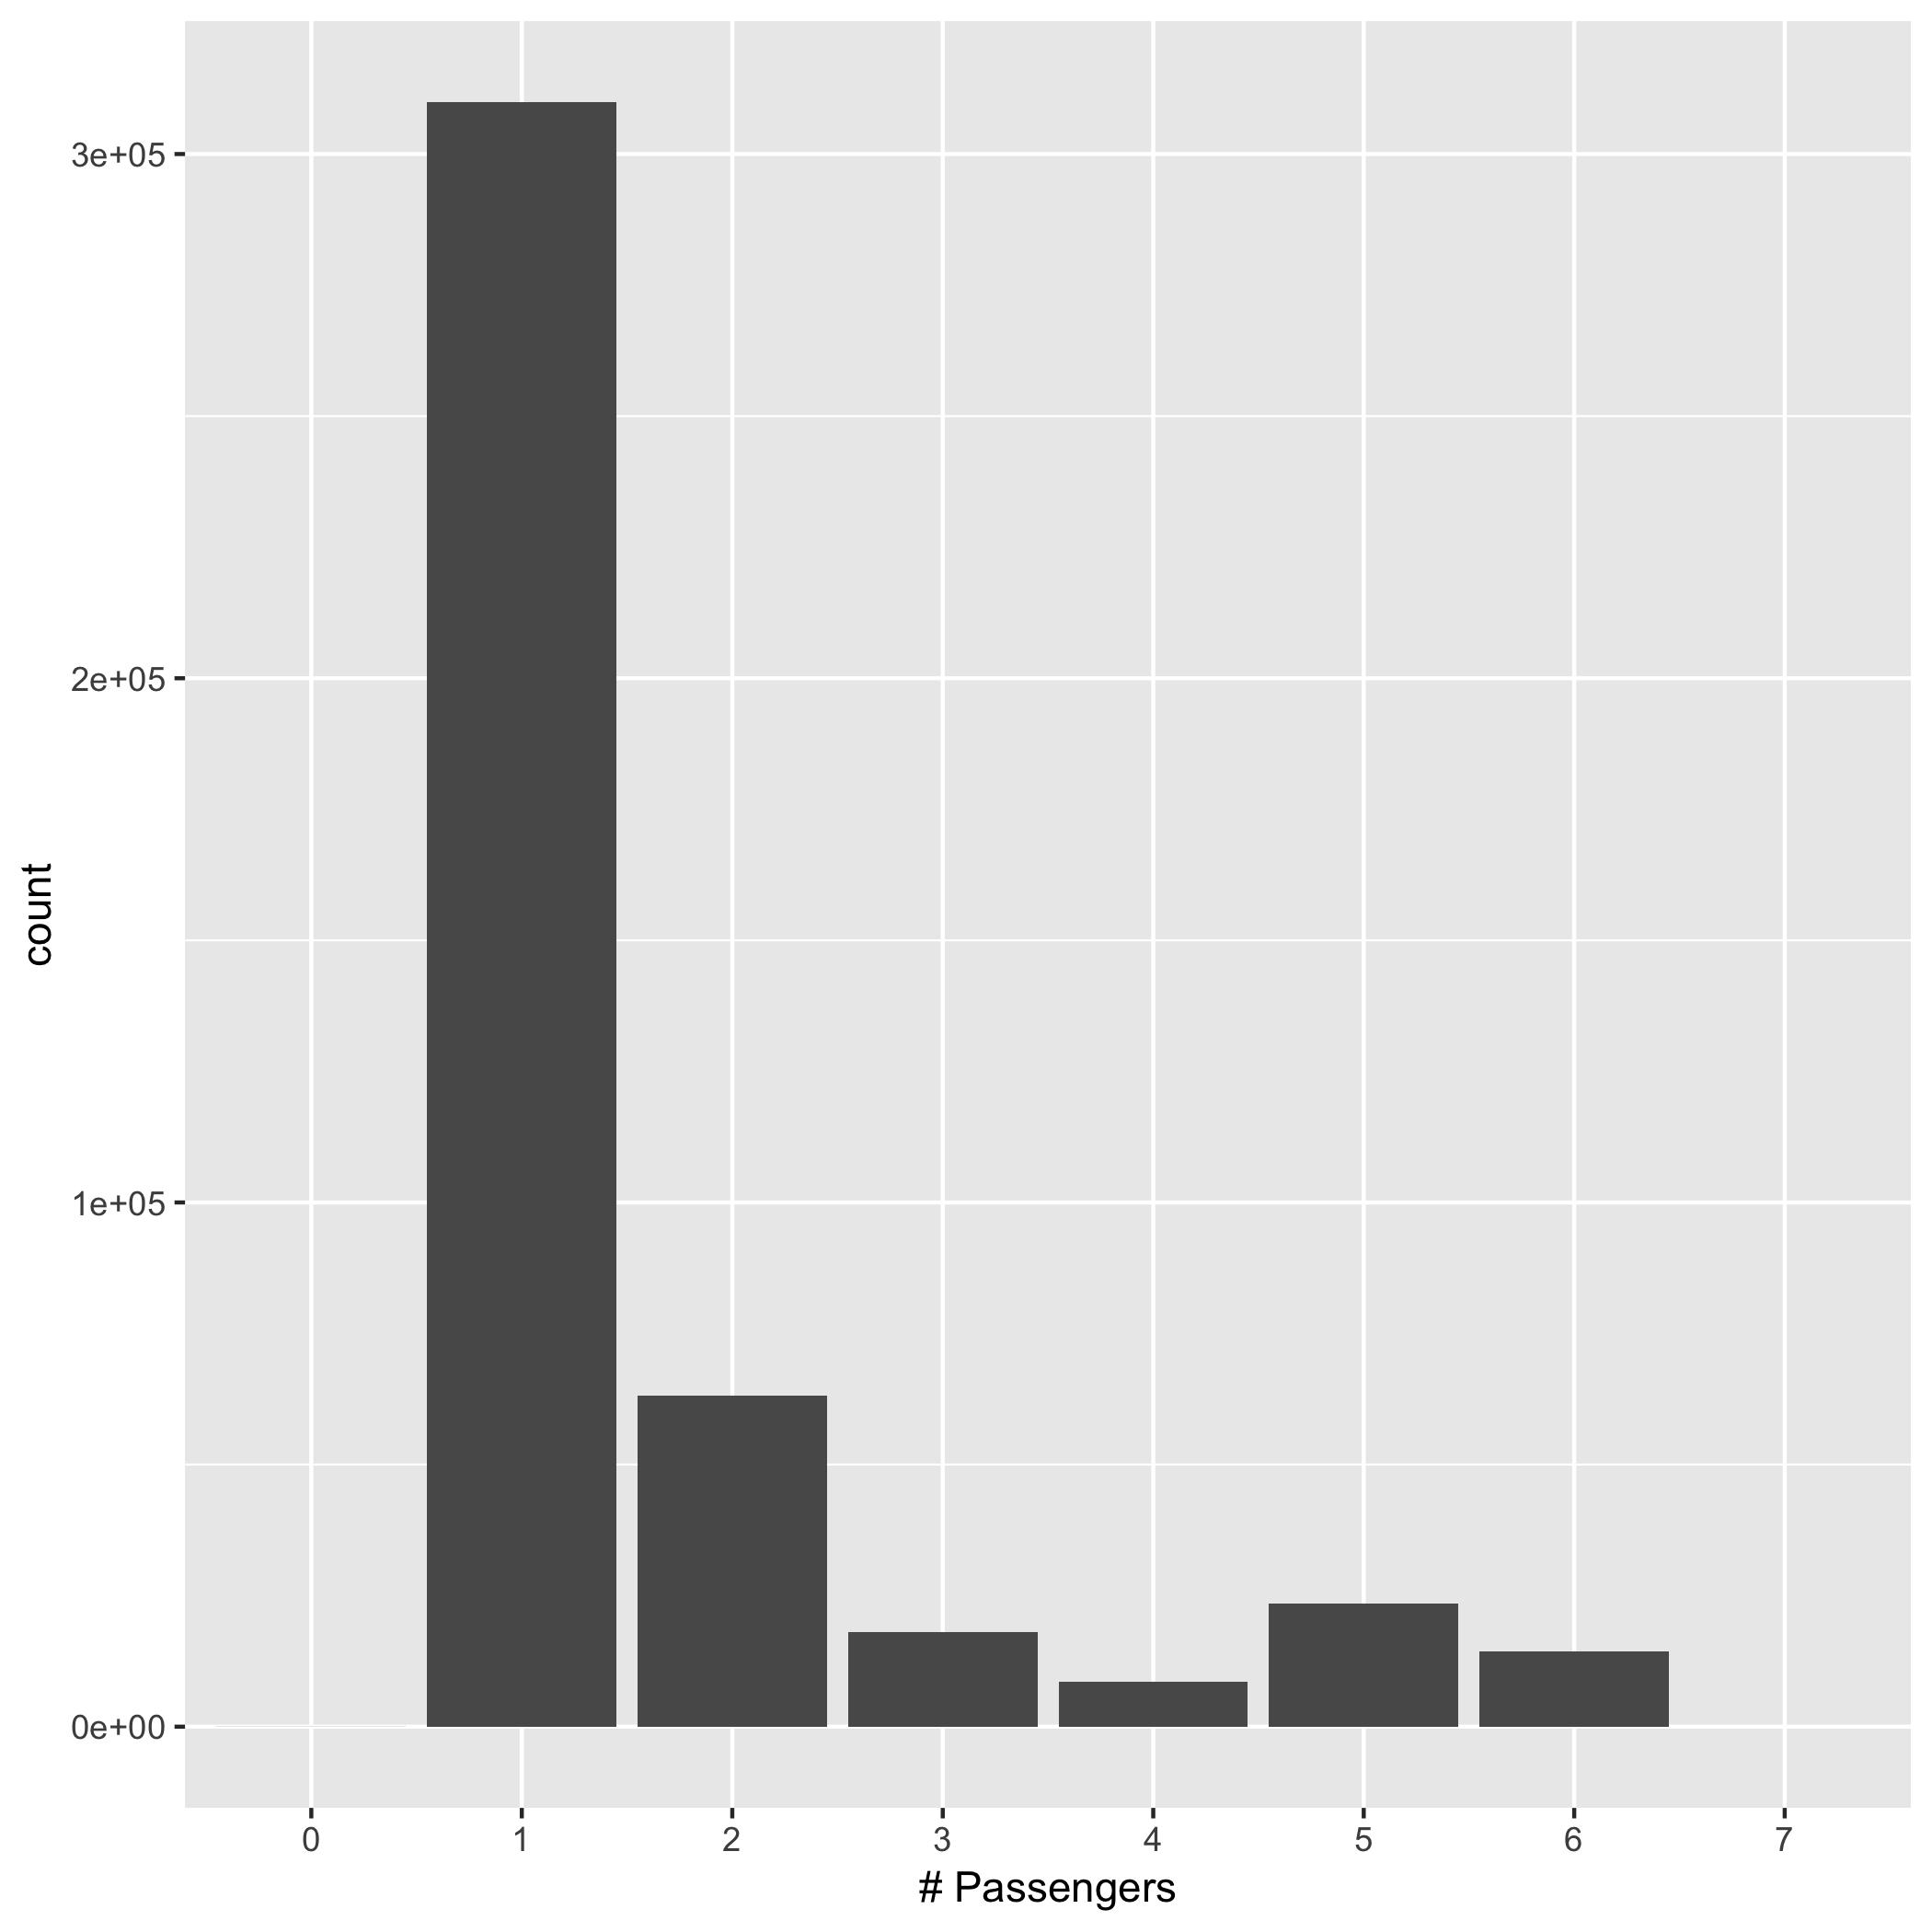

In [9]:
trainData.plot(x = passenger_count.asDiscreteVariable)
    .geomBar()
    .xLabel("# Passengers")
    .show()

LIVE@KC Analyze overall distribution of the trip duration

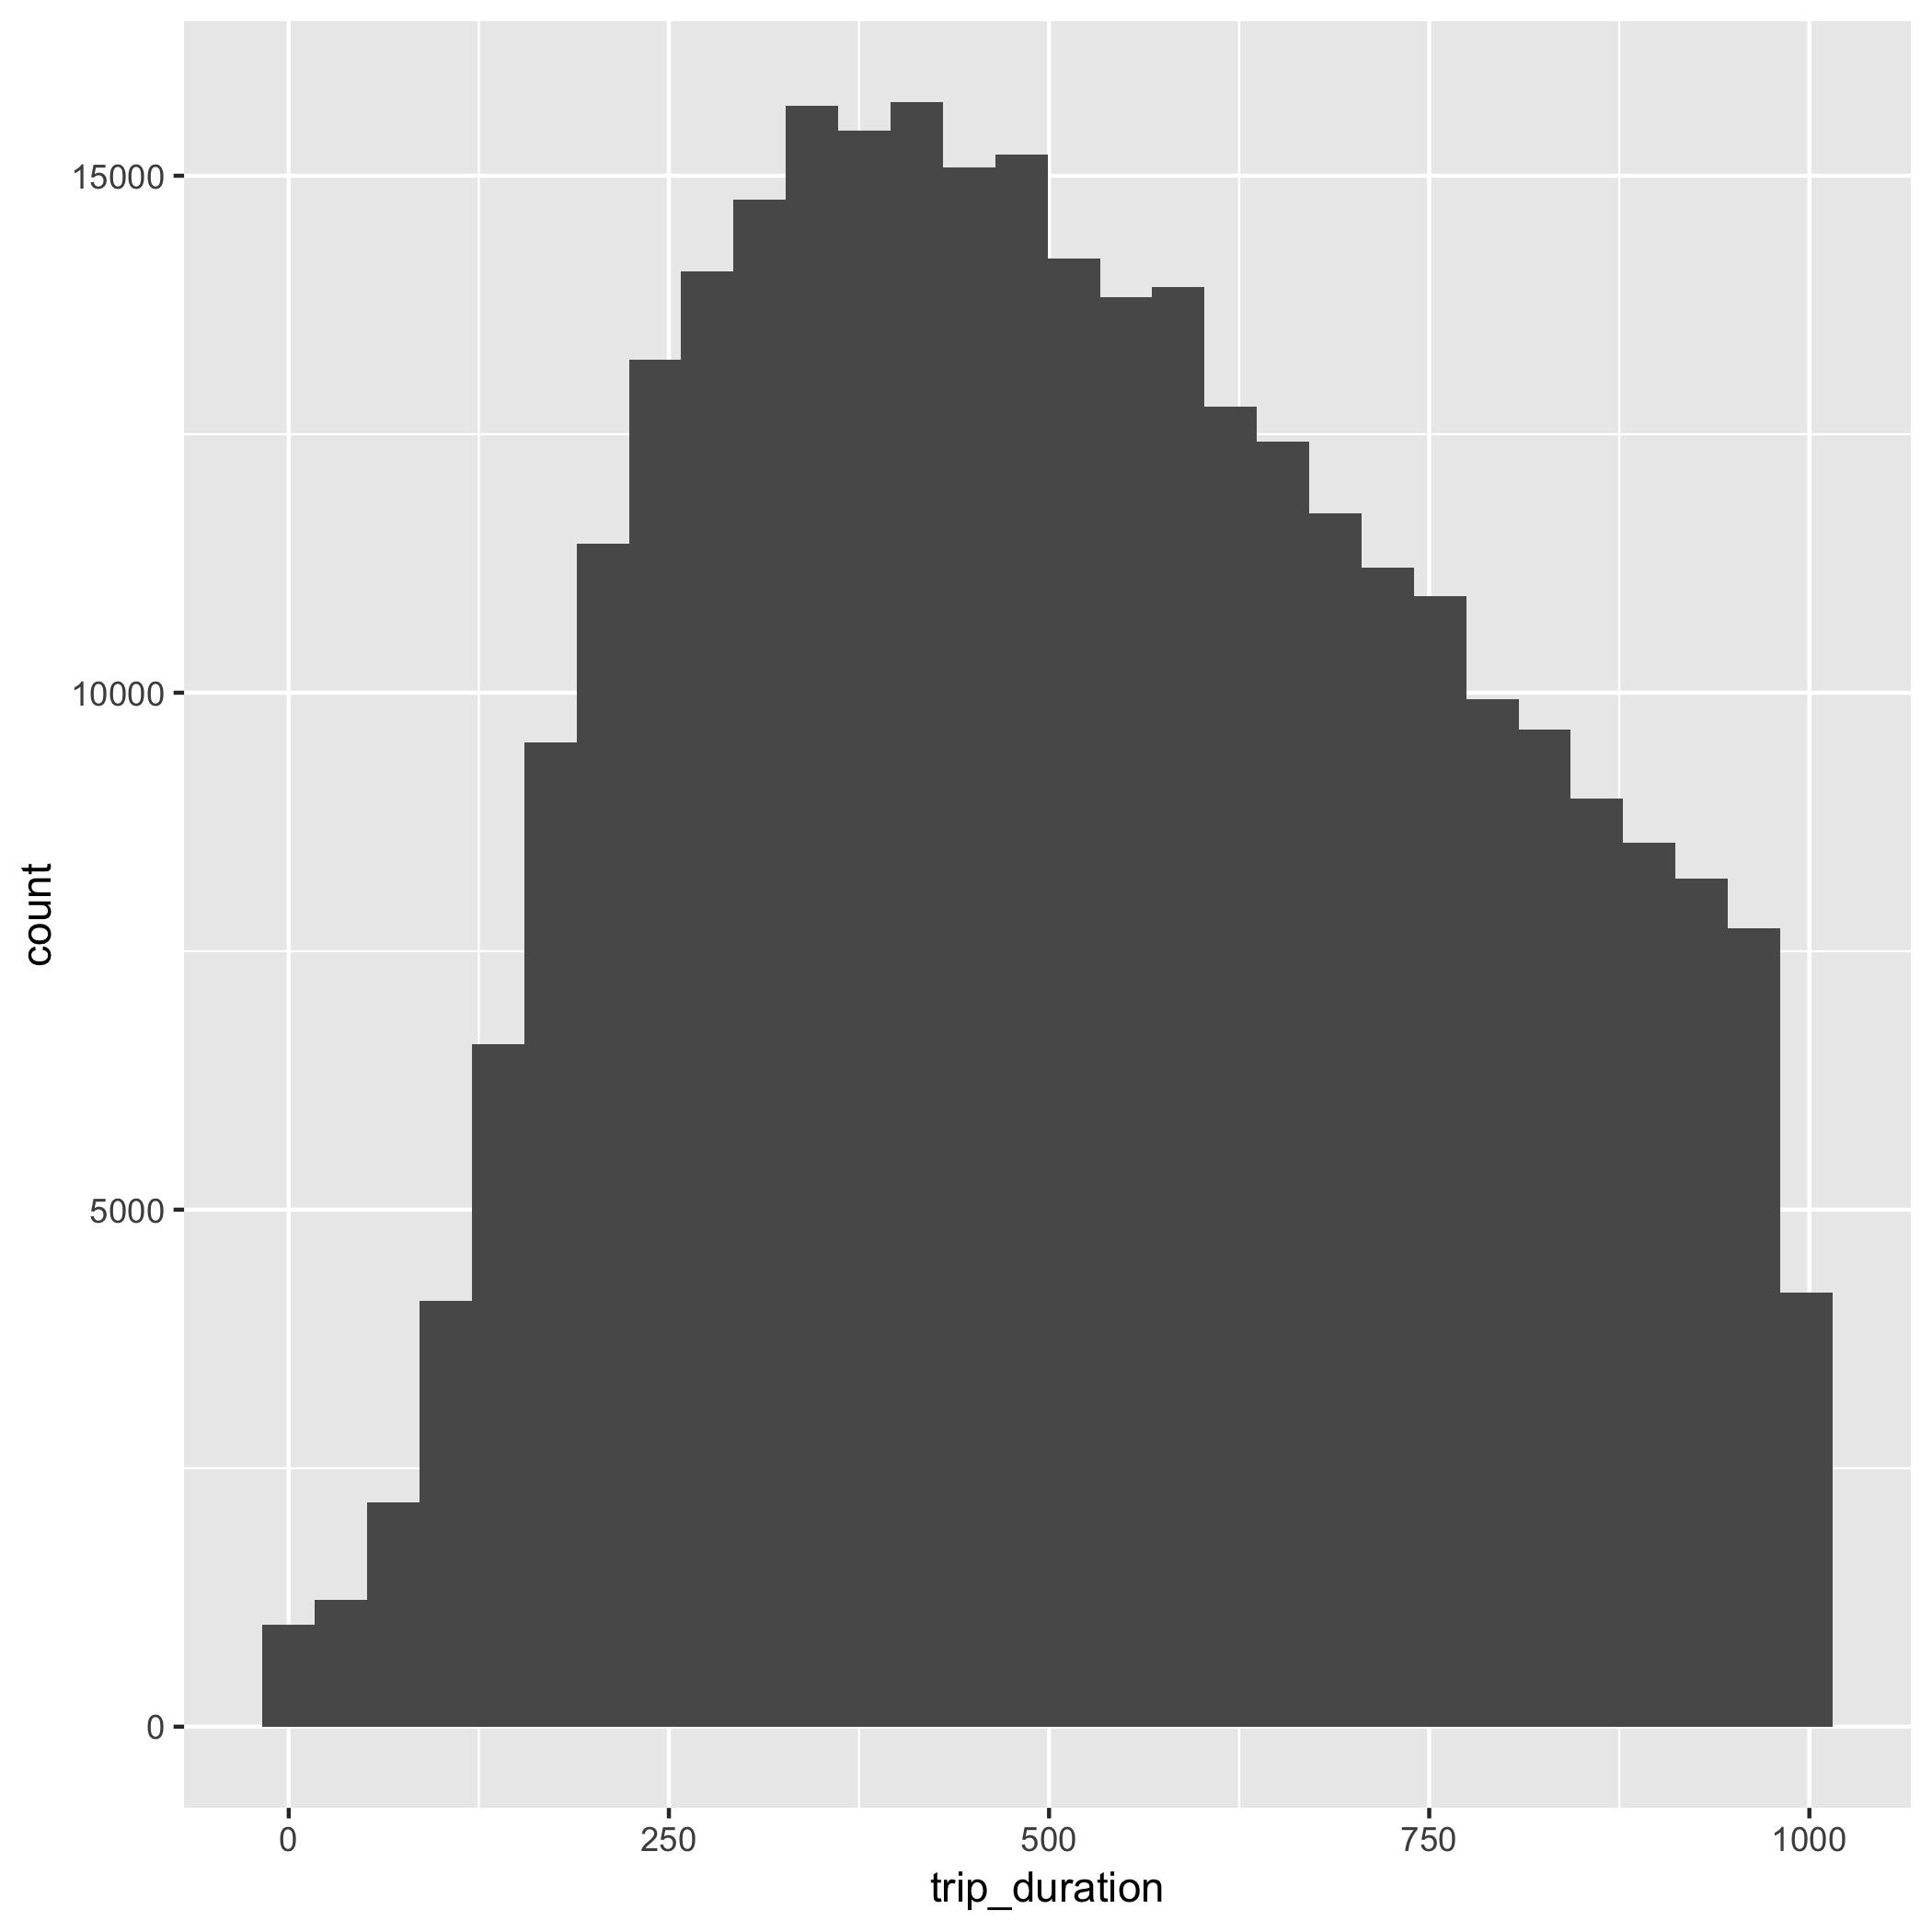

In [10]:
//trainData.plot(trip_duration).geomHistogram()
trainData.filter { it[trip_duration] lt 1000 }
    .plot(x = trip_duration)
    .geomHistogram()
    .show()

Is it really NYC?

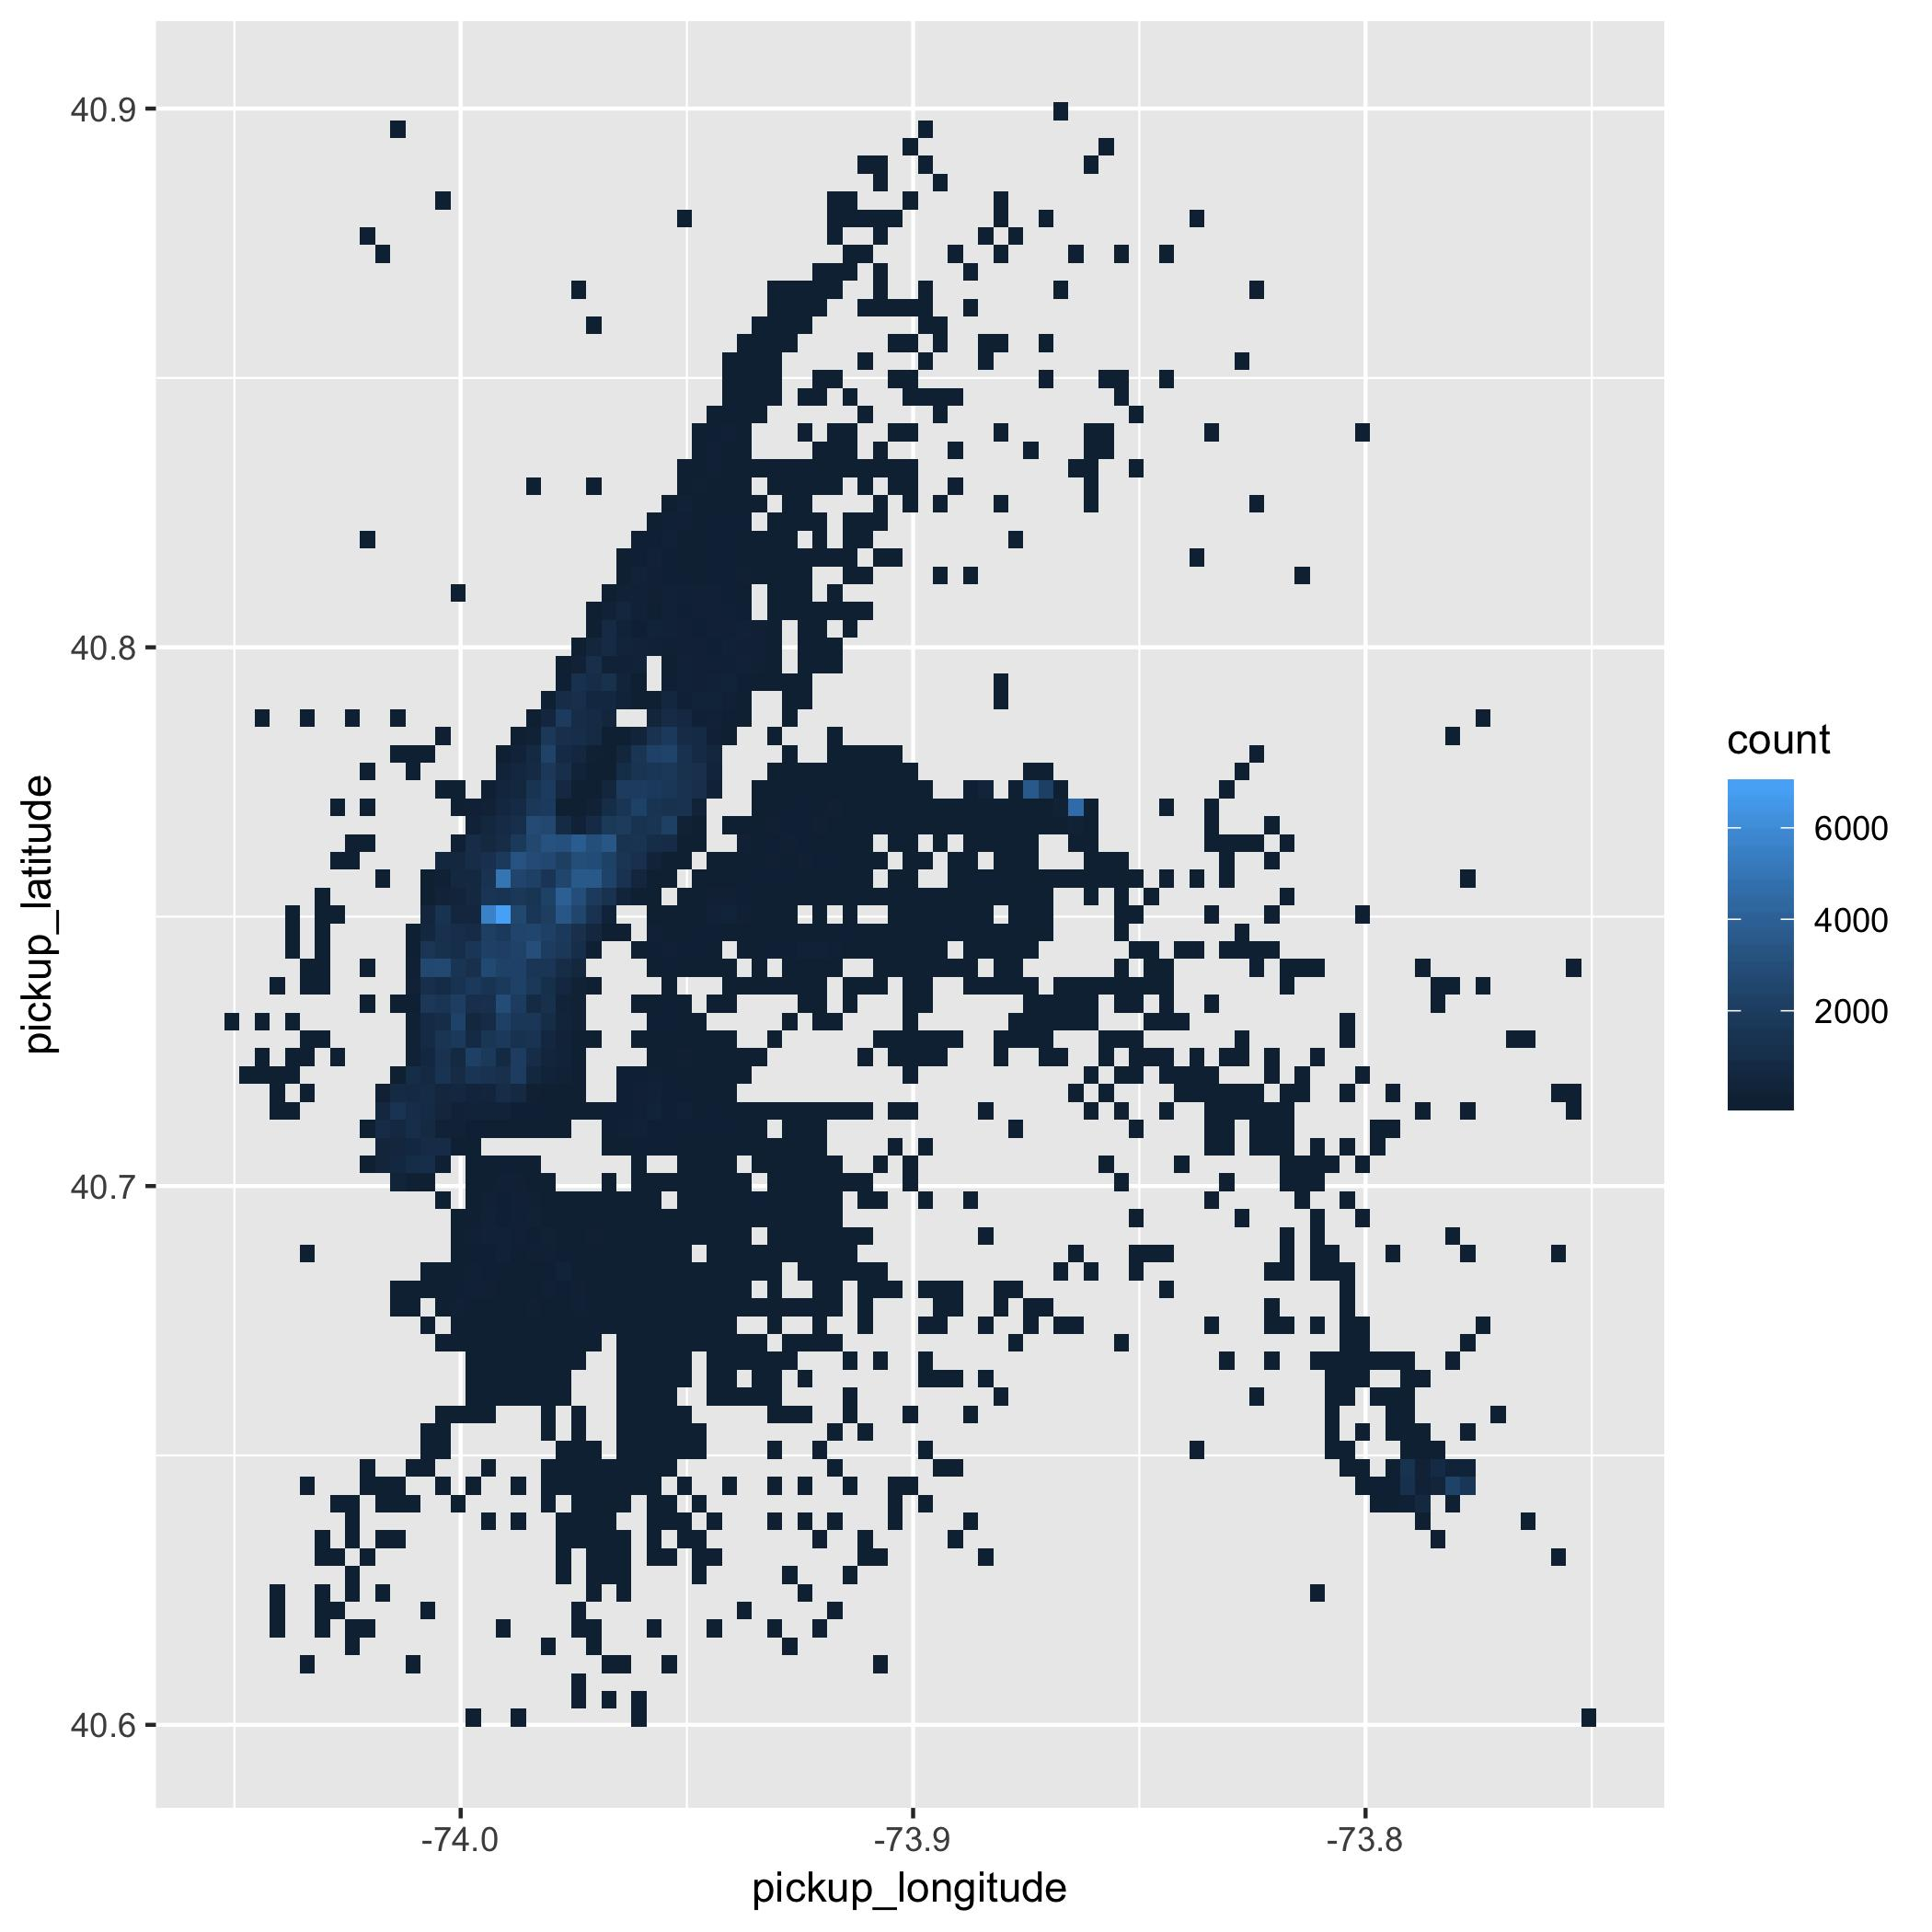

In [11]:
trainData.plot(x = pickup_longitude, y = pickup_latitude).geomPoint(alpha = .1)

fun DataFrame.constrainCoord(): DataFrame = filter {
    with(it[pickup_longitude]) { (this gt -74.05) AND (this lt -73.75) } AND
        with(it[pickup_latitude]) { (this gt 40.6) AND (this lt 40.9) }
}


trainData
    .constrainCoord()
    .plot(x = pickup_longitude, y = pickup_latitude)
    .geomPoint(alpha = .1, size = .3)
    .show()

trainData
    .constrainCoord()
    .plot(x = pickup_longitude, y = pickup_latitude)
    .geomBin2D(bins = 90)
    .show()

Correlate distance with trip duration (is it a promising predictor?)

In [12]:
trainData
    .sampleN(1e4.toInt())
    .plot(distance, trip_duration)
    .geomPoint()
    .scaleYLog10().scaleXLog10()
    .show()

Script:
library(ggplot2)
library(dplyr)
library(readr)
library(scales)
library(forcats)



data01 = read_tsv("/var/folders/cl/j57y4y2504n1nnlyd4q41fj40000gp/T/.txt5352548499846639135.tmp")

set.seed(2009)

gg = ggplot(mapping=aes(x=`distance`,y=`trip_duration`), data=data01) + 
	geom_point(stat='identity', position=position_identity(), na.rm=FALSE, inherit.aes=TRUE) + 
	scale_y_log10() + 
	scale_x_log10()

ggsave(filename="/var/folders/cl/j57y4y2504n1nnlyd4q41fj40000gp/T/tmp215537242096546675.png", plot=gg)

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
package ‘dplyr’ was built under R version 3.5.1 

Attaching package: ‘scales’

The following object is masked from ‘package:readr’:

    col_factor

Parsed with column specification:
cols(
  id = col_character(),
  vendor_id = col_integer(),
  pickup_datetime = col_dateti

try again  but with binning

In [13]:
trainData
    .plot(distance, trip_duration)
    .geomBin2D()
    .scaleYLog10().scaleXLog10()
    .show()

Script:
library(ggplot2)
library(dplyr)
library(readr)
library(scales)
library(forcats)



data01 = read_tsv("/var/folders/cl/j57y4y2504n1nnlyd4q41fj40000gp/T/.txt1802769379701187839.tmp")

set.seed(2009)

gg = ggplot(mapping=aes(x=`distance`,y=`trip_duration`), data=data01) + 
	geom_bin2d(stat='bin2d', position=position_identity(), na.rm=FALSE, inherit.aes=TRUE, bins=30) + 
	scale_y_log10() + 
	scale_x_log10()

ggsave(filename="/var/folders/cl/j57y4y2504n1nnlyd4q41fj40000gp/T/tmp7374290470061897639.png", plot=gg)

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
package ‘dplyr’ was built under R version 3.5.1 

Attaching package: ‘scales’

The following object is masked from ‘package:readr’:

    col_factor

Parsed with column specification:
cols(
  id = col_character(),
  vendor_id = col_integer(),
  pickup_datetime = col

Speed analysis

In [14]:
trainData = trainData.addColumn("speed") { it[distance] / it[trip_duration] * 3.6 }


trainData.filter { (it["speed"] gt 2) AND (it["speed"] lt 1e2) }
    .plot("speed")
    .geomHistogram(fill = RColor.red, bins = 50)
    .labs(x = "Average speed [km/h] (direct distance)")
    .show()

java.util.NoSuchElementException: Could not find column 'distance' in dataframe
	at krangl.SimpleDataFrame.get(SimpleDataFrame.kt:127)
	at krangl.TableContext.get(Extensions.kt:16)
	at Line_14$1.invoke(Line_14.kts:1)
	at Line_14$1.invoke(Line_14.kts:1)
	at krangl.SimpleDataFrame.addColumn(SimpleDataFrame.kt:191)
	at krangl.DataFrame$DefaultImpls.addColumn(DataFrame.kt:145)
	at krangl.SimpleDataFrame.addColumn(SimpleDataFrame.kt:9)

Live@KC Extract field for speed property
Speed analysis by day and hour

In [15]:
trainData.addColumn(wday) { it[wday].map<DayOfWeek> { it.value } }

java.util.NoSuchElementException: Could not find column 'wday' in dataframe
	at krangl.SimpleDataFrame.get(SimpleDataFrame.kt:127)
	at krangl.TableContext.get(Extensions.kt:16)
	at Line_15$1.invoke(Line_15.kts:1)
	at Line_15$1.invoke(Line_15.kts:1)
	at krangl.SimpleDataFrame.addColumn(SimpleDataFrame.kt:191)
	at krangl.DataFrame$DefaultImpls.addColumn(DataFrame.kt:145)
	at krangl.SimpleDataFrame.addColumn(SimpleDataFrame.kt:9)

Live@KC Visualize reasonable (<40) speeds per week day

In [16]:
trainData
    .filter { it["speed"] lt 40.0 }
    .plot(wday, "speed").geomBoxplot()
    .show()

java.util.NoSuchElementException: Could not find column 'speed' in dataframe
	at krangl.SimpleDataFrame.get(SimpleDataFrame.kt:127)
	at krangl.TableContext.get(Extensions.kt:16)
	at Line_16$1.invoke(Line_16.kts:2)
	at Line_16$1.invoke(Line_16.kts:1)
	at krangl.SimpleDataFrame.filter(SimpleDataFrame.kt:133)

Live@KC Visualize reasonable speeds also per hour

In [17]:
trainData.filter { it["speed"] lt 40.0 }
    .plot(hour.asDiscreteVariable, "speed").geomBoxplot()
    .show()

java.util.NoSuchElementException: Could not find column 'speed' in dataframe
	at krangl.SimpleDataFrame.get(SimpleDataFrame.kt:127)
	at krangl.TableContext.get(Extensions.kt:16)
	at Line_17$1.invoke(Line_17.kts:1)
	at Line_17$1.invoke(Line_17.kts:1)
	at krangl.SimpleDataFrame.filter(SimpleDataFrame.kt:133)

Live@KC wday x hours x medians

In [18]:
trainData
//    .filter { (it["speed"] lt 40.0) AND (it[trip_duration] lt 3600) }
    .groupBy(wday, hour)
    .summarize("median_speed" `=` { it["speed"].median() })
    .addColumn("wday_order") { it[wday].map<DayOfWeek> { it.value } }
    .plot(hour, reorder(wday, "wday_order"), fill = "median_speed")
    .geomTile()
    .labs(x = "Hour of the day", y = "Day of the week")
    .show()

java.lang.IllegalArgumentException: not all selected columns (wday, hour)are contained in table
	at krangl.SimpleDataFrame.select(SimpleDataFrame.kt:72)
	at krangl.SimpleDataFrame.groupBy(SimpleDataFrame.kt:257)

## Build a predictive model with xgboost

In [19]:
// https://youtrack.jetbrains.net/issue/KT-24491 and // https://github.com/khud/sparklin/issues/34)

// LIVE@KC Create helper to split train and validation data (inkl refac into extension method)
fun DataFrame.splitTrainTest(splitProportion: Double = 0.7) = shuffle().run {
    val splitter = (splitProportion * nrow).toInt()
    slice(1..splitter) to slice((splitter + 1)..nrow)
}

//val (train, validation) = trainData.splitTrainTest(splitProportion = 0.4)
// does not work yet in kshell

val dataSplit = prepareFeatures(allTrainData).splitTrainTest()
val trainMatDf = dataSplit.first
var valMatDf = dataSplit.second


fun DataFrame.selectPredictors(): DataFrame = select(
    passenger_count, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, distance, month, wday, hour, work
).oneHot<Month>(month)
    .oneHot<DayOfWeek>(wday)
    .addColumn(work) { rows.map { if (it[work] as Boolean) 1 else 0 } }


fun DataFrame.buildTrainMatrix(responseVariable: String = trip_duration): DMatrix {
    val x = selectPredictors().toFloatMatrix()
    val xLong: FloatArray = x.reduce { left, right -> left + right }
    val y = this[responseVariable].asDoubles().map { it!!.toFloat() }.toFloatArray()
    return DMatrix(xLong, nrow, ncol - 1).apply { label = y }
}

// visualize feature matrix
//trainMatDf.head(2000)
//    .addColumn("id"){rowNumber}
//    .gather("predictor", "value", columns= { except("id")})
//    .plot("predictor", "id", fill="value")
//    .geomTile()
//    .theme(axisTitleX=ElementTextBlank())


//trainMatDf.toFloatMatrix().reduce { left, right -> left + right }.size
// Construct the training input for XGBoost
val trainMat = trainMatDf.buildTrainMatrix()


val params = hashMapOf<String, Any>().apply {
    put("objective", "reg:linear")
    put("eval_metric", "rmse")
}


val watches = hashMapOf<String, DMatrix>().apply {
    put("train", trainMat)
    put("validation", valMatDf.buildTrainMatrix())
}

// number of boosting iteration =3 would just build a simple 2-step function model
val nround = 10
val booster = XGBoost.train(trainMat, params, nround, watches, null, null)

error: unresolved reference: prepareFeatures
val dataSplit = prepareFeatures(allTrainData).splitTrainTest()
                ^


How does our model look like

In [20]:
booster

error: unresolved reference: booster
booster
^


Predict trip duration

In [21]:
//var predicts = booster.predict(trainMat)
var predicts = booster.predict(valMatDf.buildTrainMatrix())

error: unresolved reference: booster
var predicts = booster.predict(valMatDf.buildTrainMatrix())
               ^
error: unresolved reference: valMatDf
var predicts = booster.predict(valMatDf.buildTrainMatrix())
                               ^


Unwrap result

In [22]:
val predictUnwrapped = predicts.map { it.first() }

predicts.size

error: unresolved reference: predicts
val predictUnwrapped = predicts.map { it.first() }
                       ^
error: unresolved reference: it
val predictUnwrapped = predicts.map { it.first() }
                                      ^
error: unresolved reference: predicts
predicts.size
^


Combine predictions with ground truth

In [23]:
val predTripDurcation = "predicted_trip_duration"
valMatDf = valMatDf.addColumn(predTripDurcation) { predictUnwrapped }
valMatDf.schema()

error: unresolved reference: valMatDf
valMatDf = valMatDf.addColumn(predTripDurcation) { predictUnwrapped }
^
error: unresolved reference: valMatDf
valMatDf = valMatDf.addColumn(predTripDurcation) { predictUnwrapped }
           ^
error: unresolved reference: predictUnwrapped
valMatDf = valMatDf.addColumn(predTripDurcation) { predictUnwrapped }
                                                   ^
error: unresolved reference: valMatDf
valMatDf.schema()
^


LIVE@KC explore correlation between ground truth and predicted duration

In [24]:
valMatDf.sampleN(10000)
    .plot(x = trip_duration, y = predTripDurcation)
    .geomPoint(alpha = .1)
    .scaleXLog10()
    .scaleYLog10()
    .show()


// explore feature importance
//booster.getFeatureScore(null)

error: unresolved reference: valMatDf
valMatDf.sampleN(10000)
^
error: unresolved reference: predTripDurcation
    .plot(x = trip_duration, y = predTripDurcation)
                                 ^


## Prepare submission file

In [25]:
fun DataFrame.buildTestMatrix(): DMatrix {
    val x = toFloatMatrix()
    val xLong: FloatArray = x.reduce { left, right -> left + right }
    return DMatrix(xLong, nrow, ncol)
}


val testFeat = prepareFeatures(testData).selectPredictors().buildTestMatrix()

var testPrediction = booster.predict(testFeat).map { it.first() }

error: unresolved reference: prepareFeatures
val testFeat = prepareFeatures(testData).selectPredictors().buildTestMatrix()
               ^
error: unresolved reference: booster
var testPrediction = booster.predict(testFeat).map { it.first() }
                     ^
error: unresolved reference: it
var testPrediction = booster.predict(testFeat).map { it.first() }
                                                     ^


LIVE@KC create final submission file

In [26]:
val kaggleSubmission = testData
    .addColumn("trip_duration") { testPrediction }
    .select("id", "trip_duration")

error: unresolved reference: testPrediction
    .addColumn("trip_duration") { testPrediction }
                                  ^


Final Results schema

In [27]:
kaggleSubmission.schema()
kaggleSubmission.writeCSV(File("kotlin4kaggle.csv"))

println("Finished first (out of N>>1) kaggle iteration using kotlin!")

error: unresolved reference: kaggleSubmission
kaggleSubmission.schema()
^
error: unresolved reference: kaggleSubmission
kaggleSubmission.writeCSV(File("kotlin4kaggle.csv"))
^


submit with
`kaggle competitions submit -c nyc-taxi-trip-duration -f kotlin4kaggle.csv -m "Proof of Concept kernel written in Kotlin"`